# First Trading Algorithm
## Pairs Trading

Pairs trading is a strategy that uses two stocks that are highly correlated. We can then use the difference in price between the two stocks as signal if one moves out of correlation with the other. It is an older strategy that is used classically as a guide to beginning algorithmic trading. There is a fantastic full guide and write up on Investopedia you can find [here](http://www.investopedia.com/university/guide-pairs-trading/)! **I highly recommend reading the article in full before continuing, it is entertaining and informative!**


Let's create our first basic trading algorithm! This is an exercise in using quantopian, **NOT** a realistic representation of what a good algorithm is! Never use something as simple as this in the real world! This is an extremely simplified version of Pairs Trading, we won't be considering factors such as cointegration!

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

!pip install quandl
import quandl

     -------------------------------------- 57.0/57.0 kB 592.1 kB/s eta 0:00:00


## United Airlines and American Airlines

In [11]:
start = '06-01-2018'
end = '06-01-2020'

In [12]:
united = quandl.get('WIKI/UAL',start_date=start,end_date=end)
american = quandl.get('WIKI/AAL',start_date=start,end_date=end)

In [13]:
united.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-01-08,69.370,69.370,68.01,68.51,4274996.0,0.0,1.0,69.370,69.370,68.01,68.51,4274996.0
2018-01-09,68.500,69.760,68.39,68.48,3028694.0,0.0,1.0,68.500,69.760,68.39,68.48,3028694.0
2018-01-10,70.980,73.151,70.45,73.08,9322187.0,0.0,1.0,70.980,73.151,70.45,73.08,9322187.0
2018-01-11,73.615,77.090,73.25,76.45,6793475.0,0.0,1.0,73.615,77.090,73.25,76.45,6793475.0
2018-01-12,76.740,78.840,76.48,78.40,4433644.0,0.0,1.0,76.740,78.840,76.48,78.40,4433644.0


In [14]:
american.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-01-08,52.60,52.64,51.930,52.13,3499793.0,0.0,1.0,52.60,52.64,51.930,52.13,3499793.0
2018-01-09,52.97,53.37,52.005,52.08,3387134.0,0.0,1.0,52.97,53.37,52.005,52.08,3387134.0
2018-01-10,53.23,54.02,52.880,53.78,7622514.0,0.0,1.0,53.23,54.02,52.880,53.78,7622514.0
2018-01-11,54.49,57.00,54.180,56.42,11304243.0,0.0,1.0,54.49,57.00,54.180,56.42,11304243.0
2018-01-12,56.56,58.73,56.560,58.47,7490353.0,0.0,1.0,56.56,58.73,56.560,58.47,7490353.0


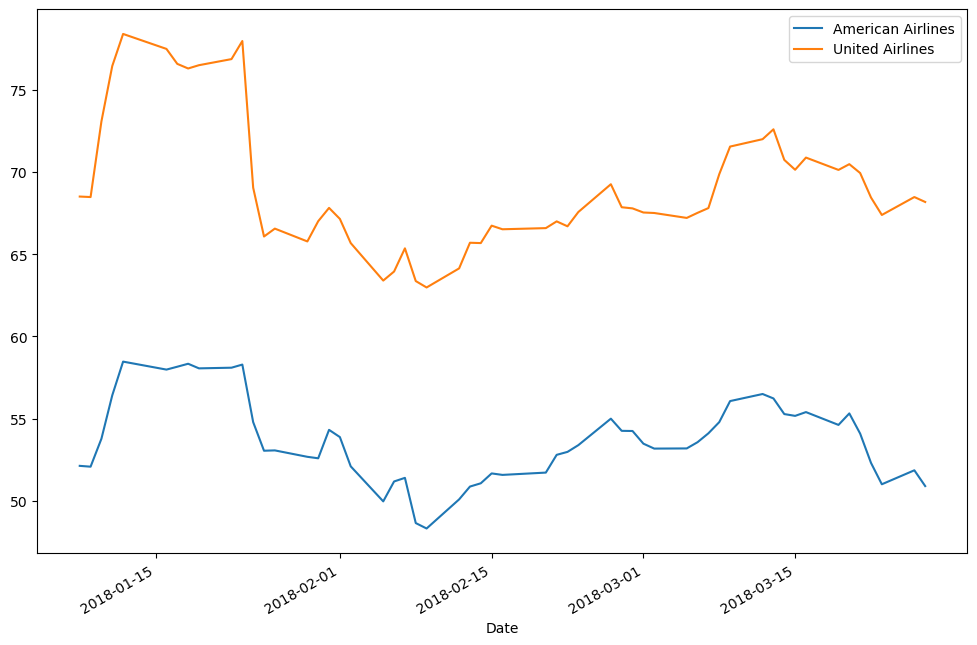

In [15]:
american['Adj. Close'].plot(label='American Airlines',figsize=(12,8))
united['Adj. Close'].plot(label='United Airlines')
plt.legend()

## Spread and Correlation

In [16]:
np.corrcoef(american['Adj. Close'],united['Adj. Close'])

array([[1.        , 0.91693453],
       [0.91693453, 1.        ]])

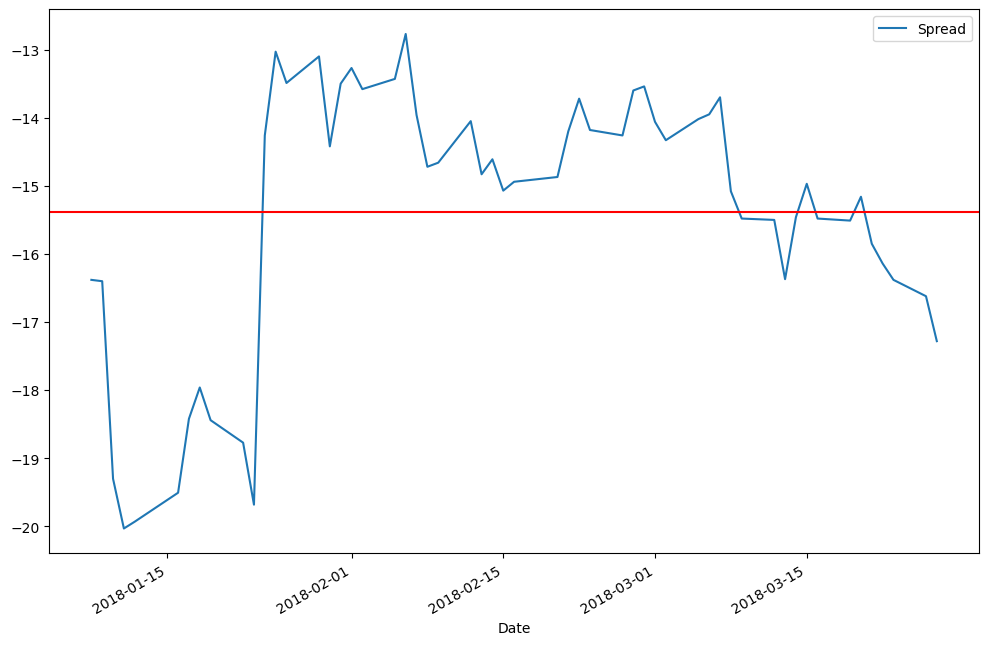

In [17]:
spread = american['Adj. Close'] - united['Adj. Close']
spread.plot(label='Spread',figsize=(12,8))
plt.axhline(spread.mean(),c='r')
plt.legend()

### Normalizing with a z-score

In [18]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

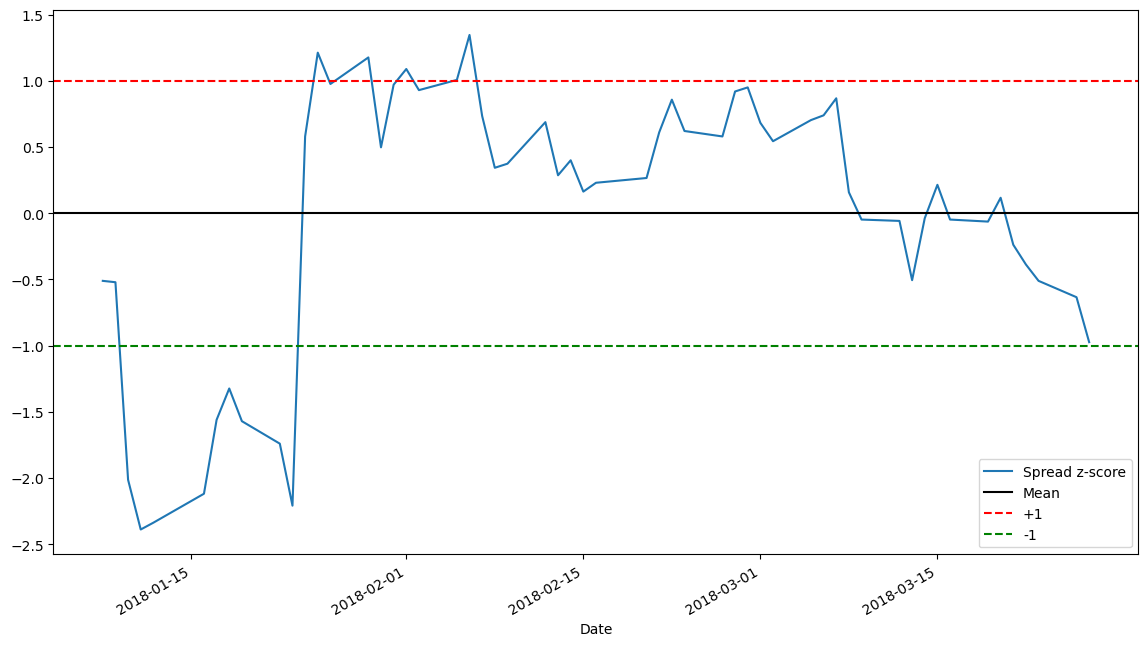

In [19]:
zscore(spread).plot(figsize=(14,8))
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, c='r', ls='--')
plt.axhline(-1.0, c='g', ls='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### Rolling Z-Score

Our spread is currently American-United. Let's decide how to calculate this on a rolling basis for our use in Quantopian

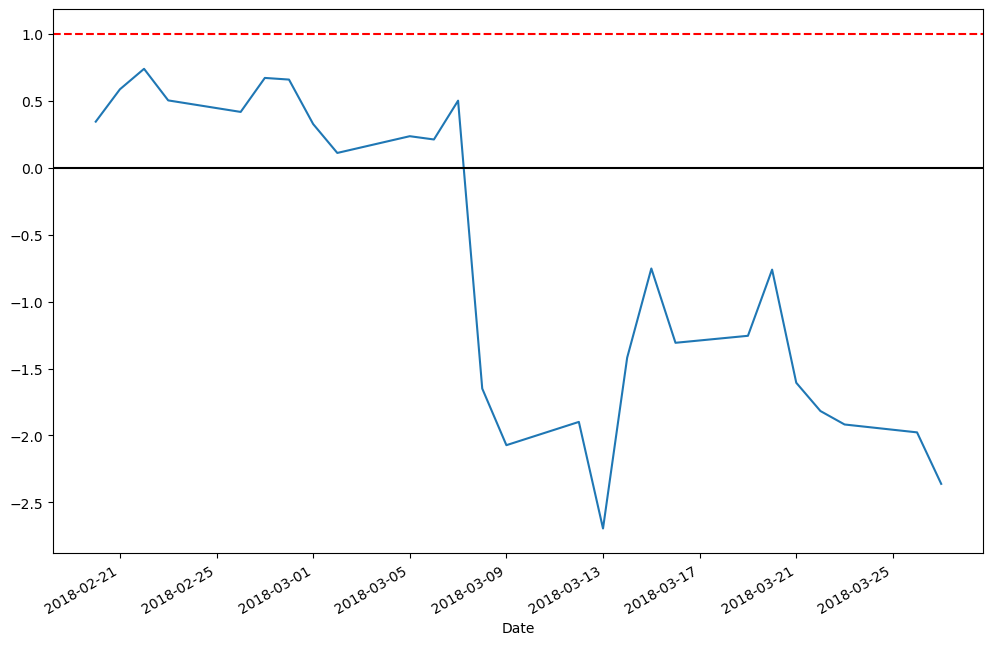

In [20]:
#1 day moving average of the price spread
spread_mavg1 = spread.rolling(1).mean()

# 30 day moving average of the price spread
spread_mavg30 = spread.rolling(30).mean()

# Take a rolling 30 day standard deviation
std_30 = spread.rolling(30).std()

# Compute the z score for each day
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30



zscore_30_1.plot(figsize=(12,8),label='Rolling 30 day Z score')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

## Implementation of Strategy

#### WARNING: YOU SHOULD NOT ACTUALLY TRADE WITH THIS!

In [21]:
import numpy as np
 
def initialize(context):
    """
    Called once at the start of the algorithm.
    """   
    
    # Every day we check the pair status
    schedule_function(check_pairs, date_rules.every_day(), time_rules.market_close(minutes=60))
    
    # Our Two Airlines
    context.aa = sid(45971) #aal
    context.ual = sid(28051) #ual   
    
    # Flags to tell us if we're currently in a trade
    context.long_on_spread = False
    context.shorting_spread = False


def check_pairs(context, data):
    
    # For convenience
    aa = context.aa
    ual = context.ual
    
    # Get pricing history
    prices = data.history([aa, ual], "price", 30, '1d')
    
 
    # Need to use .iloc[-1:] to get dataframe instead of series
    short_prices = prices.iloc[-1:]
    
    # Get the long 30 day mavg
    mavg_30 = np.mean(prices[aa] - prices[ual])
    
    # Get the std of the 30 day long window
    std_30 = np.std(prices[aa] - prices[ual])
    
    # Get the shorter span 1 day mavg
    mavg_1 = np.mean(short_prices[aa] - short_prices[ual])
    
    # Compute z-score
    if std_30 > 0:
        zscore = (mavg_1 - mavg_30)/std_30
    
        # Our two entry cases
        if zscore > 0.5 and not context.shorting_spread:
            # spread = aa - ual
            order_target_percent(aa, -0.5) # short top
            order_target_percent(ual, 0.5) # long bottom
            context.shorting_spread = True
            context.long_on_spread = False
            
        elif zscore < -0.5 and not context.long_on_spread:
            # spread = aa - ual
            order_target_percent(aa, 0.5) # long top
            order_target_percent(ual, -0.5) # short bottom
            context.shorting_spread = False
            context.long_on_spread = True
            
        # Our exit case
        elif abs(zscore) < 0.1:
            order_target_percent(aa, 0)
            order_target_percent(ual, 0)
            context.shorting_spread = False
            context.long_on_spread = False
        
        record('zscore', zscore)